<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/Binary%20classification/Home%20Credit%20Default%20Risk/Introduction%3A%20Home%20Credit%20Default%20Risk%20Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Home Credit Defalut Risk Competition 데이터를 기반으로 Feature를 생성하는 방법을 다루고 있다.
- 모델을 만들기 위해 application 데이터만 사용
-  리더보드에서 약 0.74를 기록


# Imports


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import os
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# Read in Data

In [3]:
!pip install gcsfs

     |████████████████████████████████| 125 kB 10.2 MB/s 
     |████████████████████████████████| 1.3 MB 42.3 MB/s 
     |████████████████████████████████| 160 kB 57.6 MB/s 
     |████████████████████████████████| 294 kB 61.7 MB/s 


In [4]:
GCS_DS_PATH = "gs://kds-787872192ad94e1a7c298920b667e35fb4c27c150b990091dec85d37"
app_train = pd.read_csv(GCS_DS_PATH+'/application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
app_test = pd.read_csv(GCS_DS_PATH+'/application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# EDA

In [6]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

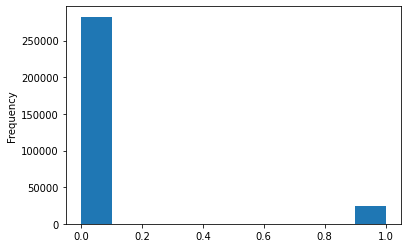

In [7]:
app_train['TARGET'].astype(int).plot.hist();

## 결측치 확인

In [8]:
# 결측치 계산 함수
def missing_values_table(df):
  # 총 결측치
  mis_val = df.isnull().sum()
  # 결측률
  mis_val_percent = 100 * df.isnull().sum()/len(df)
  # 결과테이블 만듬
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
  # 칼럼 이름 재지정
  mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
  # 결측률 내림차순으로 테이블 정렬
  mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1]!=0].sort_values('% of Total Values', ascending=False).round(1)

  # summary 출력
  print("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
  "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")

  # 결측치 데이터 프레임 리턴
  return mis_val_table_ren_columns

In [9]:
# 결측치 통계
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


## 칼럼 타입

In [10]:
# 칼럼 갯수
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
# 유니크 클래스 갯수
app_train.select_dtypes('object').apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

## categorical 변수 인코딩
2개의 categorical 변수는 라벨인코딩, 2개 이상의 categorical 변수는 원 핫 인코딩 사용


In [12]:
# 라벨인코딩 
le = LabelEncoder()
le_count = 0

# 칼럼 반복
for col in app_train:
  if app_train[col].dtype == 'object':
    # 유니크 카테고리 2개 이하
      if len(list(app_train[col].unique())) <= 2:
        # training data 학습
        le.fit(app_train[col])
        # training data, testing data 변환
        app_train[col] = le.transform(app_train[col])
        app_test[col] = le.transform(app_test[col])
        # 라벨 인코딩된 열 수 추적
        le_count += 1

print('%d개의 칼럼 label encoded됨' % le_count)

3개의 칼럼 label encoded됨


In [13]:
# 원핫인코딩
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


## Training and Testing Data 조정(align)


*   training and testing data 동일한 피처 있어야 함
*   train 데이터의 One-hot encoding은 더 많은 칼럼 만듬. test 데이터에 표시되지 않는 변수 있기 때문
- test 데이터에 없는 데이터의 열을 제거하려면 train데이터 프레임을 align해야 함


- 먼저 target column 따로 추출해야 함(test 데이터에 없기때문)
- 정렬 시 axis=1로 행이 아닌 열 기준으로 데이터 프레임을 정렬해야 함



In [14]:
train_labels = app_train['TARGET']

# train과 test 데이터 둘 다 있는 칼럼 따로 저장
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# target 값 더해줌
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


## Back to Exploratory Data Analysis

Anomalies  
EDA 수행 시 데이터 내의 anomalies(이상현상)에 주의해야 함
- 잘못 입력된 숫자, 측정 장비의 오류 또는 유효하지만 극단적인 측정 때문
- 열의 통계를 통해 살펴볼 수 있음

DAYS_BIRT
- 'DAYS_BIRT' 열의 숫자는 현재 대출 신청과 비교하여 기록되기 때문에 음수임
- 연도 단위로 보려면, -1로 반올림하고 일 수로 나눌 수 있음

In [15]:
(app_train['DAYS_BIRTH']/ -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

DAYS_BIRT 즉, 나이 변수는 이상값은 없어보인다.

DAYS_EMPLOYED


In [16]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

DAYS_EMPLOYED는 최대값이 약 1000년을 넘는 이상값이 존재한다.

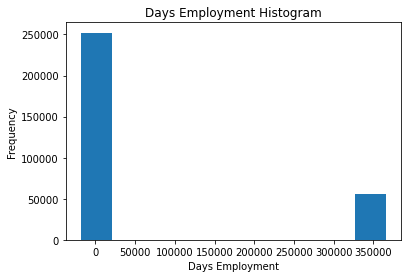

In [17]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

비정상적인 이상값의 부분 집합이 다른 값들보다 높은지 낮은지 확인 

In [18]:
anom = app_train[app_train['DAYS_EMPLOYED']==365243]
non_anom = app_train[app_train['DAYS_EMPLOYED']!=365243]
print('The non-anomalies default on %0.2f%% of loans' % (100*non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


이상값 비율이 더 낮음

이상치 처리 방법으로, 이상 징후를 결측치로 설정한 다음 기계 학습 전에 이상 징후를 기입하는 방법이 있다.
- 이러한 경우 같은 중요도를 나타냄
- 숫자(np.nan)가 아닌 비정상적인 값을 입력한 다음 값이 비정상적인지 여부를 나타내는 새로운 부울 열을 만들 수 있음


# Feature Engineering
Feature Engineering은 캐글 competitions에서 매우 중요한 요소이다.
- 올바른 모형과 최적 설정을 선택하는 것도 중요하지만 모형은 주어진 데이터에서만 학습할 수 있다.
- 따라서 데이터가 모델 작업과 관련이 있는지 확인해야한다.

Feature Engineering은 다음 두가지 모두를 포함한다.
- feature construction: 기존 데이터에서 새로운 features 추가
- feature selection: 가장 중요한 features 또는 다른 차원 축소 방법 선택

이 커널서는 두가지 방법을 시도할 것이다.
- Polynomial features
- Domain knowledge features

## Polynomial Features
- polynomial features은 간단한 feature construction 방법 중 하나이다.
- 이 방법에서는 상호작용 feature 뿐만 아니라 제곱 형태 feature도 만든다.
- 여러 개별 변수의 조합인 이러한 특성은 변수 간의 교호작용을 나타낸다. 
- 두 변수 자체로는 target값에 큰 영향을 미치지 않지만, 두 변수를 단일 교호작용 변수로 결합하면 target값과의 관계를 나타낼 수 있다. 
- 교호작용 항은 여러 변수의 효과를 포착하기 위해 통계에서는 쓰이지만, 일반적으로 machine learning에서는 자주 사용되지는 않는다. 


하지만 이번 커널에서는 우리 모델에 도움이 될 수 있는지 몇가지 방법을 시도해 볼 것이다.
- 다음 코드에서는 EXT_SOURCE와 DAYS_BIRTH 변수를 사용하여 polynomial features를 만든다. 
- Scikit-Learn에는 다항식 및 상호작용 항을 지정된 차수까지 생성하는 기능이 있다.
- 우리는 3차수를 사용할 것이다. 너무 차수가 높으면 기하급수적으로 확장되어 과적합 문제가 발생할 수 있다.

In [19]:
# polynomial features를 위한 데이터 프레임을 만듬
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

In [20]:
# 결측값 처리를 위한 계산
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])

In [21]:
# 결측값을 채움
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

In [22]:
# 지정된 차수의 polynomial object 만들기
from sklearn.preprocessing import PolynomialFeatures
poly_transformer = PolynomialFeatures(degree=3)

In [23]:
# polynomial features 학습
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [24]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

35개의 feature가 만들어졌음. 

이제 이러한 feature가 target과 얼마나 상관관계를 가지는지 확인


In [25]:
# 데이터 프레임 만듬
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
# 타겟값 추가
poly_features['TARGET'] = poly_target

# 상관성 찾음
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


모델을 만들 때, 이러한 특징들이 실제로 모델 학습에 도움이 되는지 판단할 수 있다.

In [26]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

# polynomial features를 train 데이터에 합치기
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# polynomial features를 test 데이터에 합치기
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

In [27]:
# 데이터 프레임 정렬
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


## Domain Knowledge Features

- CREDIT_INCOME_PERCENT: 고객의 소득 대비 신용 금액의 백분율
- ANNUITY_INCOME_PERCENT: 고객의 소득 대비 대출연금의 비율
- CREDIT_TERM: 연금 지급 기간(월)
- DAYS_EMPLOYED_PERCENT: 고객의 연령에 대한 고용 일수 비율


In [28]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

In [29]:
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [30]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

Visualize New Variables - KDE plot

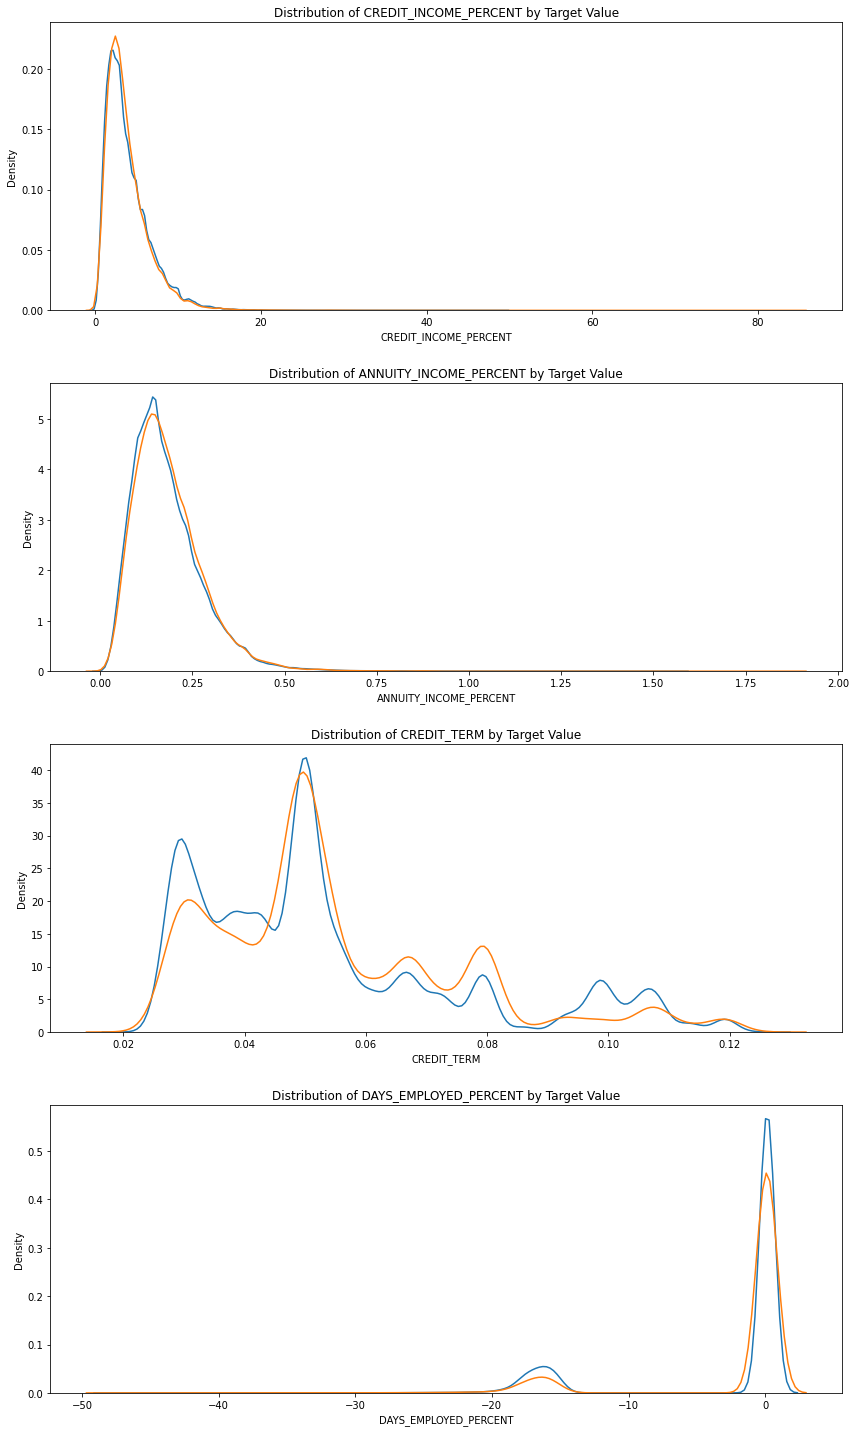

In [31]:
plt.figure(figsize = (12, 20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
  # create a new subplot
  plt.subplot(4, 1, i+1)
  # plot repaid loans
  sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==0, feature], label = 'target == 0')
  # plot loans that were not repaid
  sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET']==1, feature], label = 'target == 1')

  # Label the plots
  plt.title('Distribution of %s by Target Value' % feature)
  plt.xlabel('%s' % feature);
  plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

# Baseline

Logistic Regression Implementation

In [32]:
from sklearn.preprocessing import MinMaxScaler

# training data로부터 target 값 삭제
if 'TARGET' in app_train:
  train = app_train.drop(columns = ['TARGET'])
else:
  train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# 결측치 중간값으로 대체
imputer = SimpleImputer(strategy='median')

# 스케일링 범위 0~1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


## LogisticRegression
- 정규화 매개변수 C를 낮추어가며 변경
- C는 과적합 양을 제어(낮을수록 과적합이 감소)
- 먼저 모델을 학습한 다음 predict_proba를 사용하여 테스트 데이터 예측

In [33]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.0001)

log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

- predict_proba 모델 m*2 배열 반환
- m은 관측치 수
- 첫 번째 열은 목표값이 0일 확률이고 두번째는 목표값이 1일 확률
- 대출금이 상환되지 않을 확률을 원하기 때문에 두 번째 열을 선택

In [34]:
 log_reg.predict_proba(test)

array([[0.9346855 , 0.0653145 ],
       [0.88197172, 0.11802828],
       [0.93162763, 0.06837237],
       ...,
       [0.93352724, 0.06647276],
       [0.92766098, 0.07233902],
       [0.91075146, 0.08924854]])

In [35]:
log_reg_pred = log_reg.predict_proba(test)[:,1]

예측은 sample_submission.csv 이어야 함(열은 SK_ID_CURR and TARGET)
- 테스트 세트와 예측 데이터프레임 형식 만듬

In [36]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred
submit.head()

,SK_ID_CURR,TARGET
0,100001,0.065314
1,100005,0.118028
2,100013,0.068372
3,100028,0.070768
4,100038,0.118071


In [37]:
# Save the submission to a csv file
submit.to_csv('log_reg_baseline.csv', index = False)

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100,
                                       random_state = 50,
                                       verbose = 1,
                                       n_jobs = -1)

In [39]:
random_forest.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.3min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [40]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance':feature_importance_values})

predictions = random_forest.predict_proba(test)[:,1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.8s finished


In [41]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission to a csv file
submit.to_csv('random_forest_baseline.csv', index = False)

모델 점수 약 0.678점

Make Predictions using Engineered Features

*   Polynomial Features 와 Domain knowledge가 모델 개선시켰는지 비교


Testing Polynomial Features 

In [42]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = SimpleImputer(strategy='median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100,
                                            random_state = 50,
                                            verbose = 1,
                                            n_jobs = -1)

In [43]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


In [44]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index = False)

Testing Domain Features

In [45]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')
domain_features_names = list(app_train_domain.columns)

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100,
                                              random_state = 50,
                                              verbose = 1,
                                              n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# 피쳐 중요도 추출
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance':feature_importance_values_domain})

# test data에서 예측값 만들기
predictions = random_forest_domain.predict_proba(domain_features_test)[:,1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.4min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.7s finished


In [46]:
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_domain.csv', index = False)

위 모델의 점수는 0.679점으로 피쳐엔지니어링이 도움이 되지 않았다는 것을 보여준다.

## Model Interpretation: Feature Importances
가장 관령성이 높은 변수를 확인하는 간단한 방법으로 Feature Importances를 살펴볼 수 있다.
- EDA에서 본 상관관계를 고려 할 때, 가장 중요한 특징이 EXT_SOURCE 와 DAYS_BIRTH 임을 알 수 있다.

In [49]:
def plot_feature_importances(df):
  df = df.sort_values('importance', ascending = False).reset_index()
  # 정규화
  df['importance_normalized'] = df['importance'] / df['importance'].sum()
  # 수평 바 차트 만듬
  plt.figure(figsize = (10, 6))
  ax = plt.subplot()

  # 가장 높은 중요도를 맨 위로 오게 하기 위해 인덱스를 뒤집음
  ax.barh(list(reversed(list(df.index[:15]))),
          df['importance_normalized'].head(15),
          align = 'center', edgecolor = 'k')
  
  # Set the yticks and labels
  ax.set_yticks(list(reversed(list(df.index[:15]))))
  ax.set_yticklabels(df['feature'].head(15))

  # Plot labeling
  plt.xlabel('Normalized Importance'); 
  plt.title('Feature Importances')
  plt.show()
  
  return df

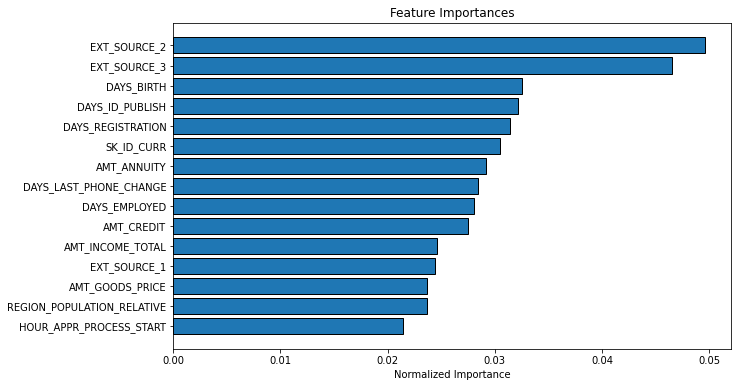

In [50]:
feature_importances_sorted = plot_feature_importances(feature_importances)

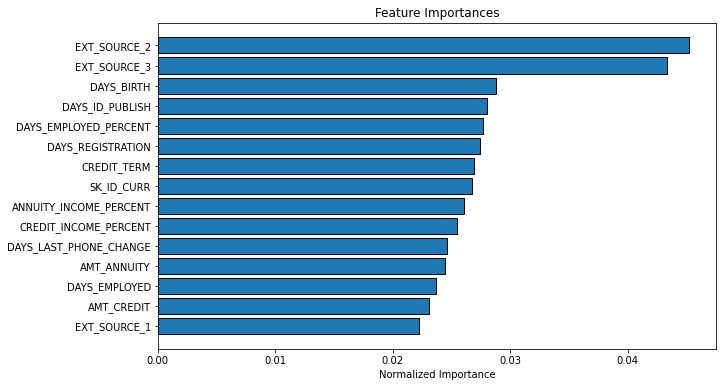

In [51]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)